In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import preprocessing

In [8]:
pd.set_option('display.max_columns', 184)
pd.set_option('display.max_rows', 184)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_seq_items', 184)
pd.set_option('display.width', 100)

In [13]:
# chargement du dataset
df_cheese = pd.read_csv("Data/cheese_clean.csv", index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## fonctions à utiliser

In [3]:
def histplot(cols, log=False):
    '''
    faire plusieurs histrogramme dans un bloc
    '''
    plt.figure(figsize=(30,20))
    for i, col in enumerate(cols):
        plt.subplot(3, 3, i+1)
        plt.hist(df_cheese[col], bins=100)
        plt.xlabel(col)
        if log:
            plt.yscale('log')

In [4]:
def topCorrel(df, seuil):
    '''
    liste les variables des plus au moins correlées
    '''
    liste_top = pd.Series()
    correl = df.corr()
    for iind, i in enumerate(correl.columns):
        for rind, r in enumerate(correl.index):
            if iind < rind:
                if abs(correl.loc[i,r]) >= seuil:
                    liste_top[i+ ' - '+r] = correl.loc[i,r]
            else:
                pass
    return liste_top.sort_values(ascending=False)

In [5]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [6]:
from matplotlib.collections import LineCollection
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(15,15))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [7]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

## Analyse univariée

### distribution du nutriscore et de l'ecoscore
à savoir, le nutriscore et l'ecoscore sont un indice qui, plus il croît, moins son score est "bon"
(plus le score est faible, meilleurs est la qualitée du produit)

<AxesSubplot:xlabel='ecoscore_score_fr', ylabel='Density'>

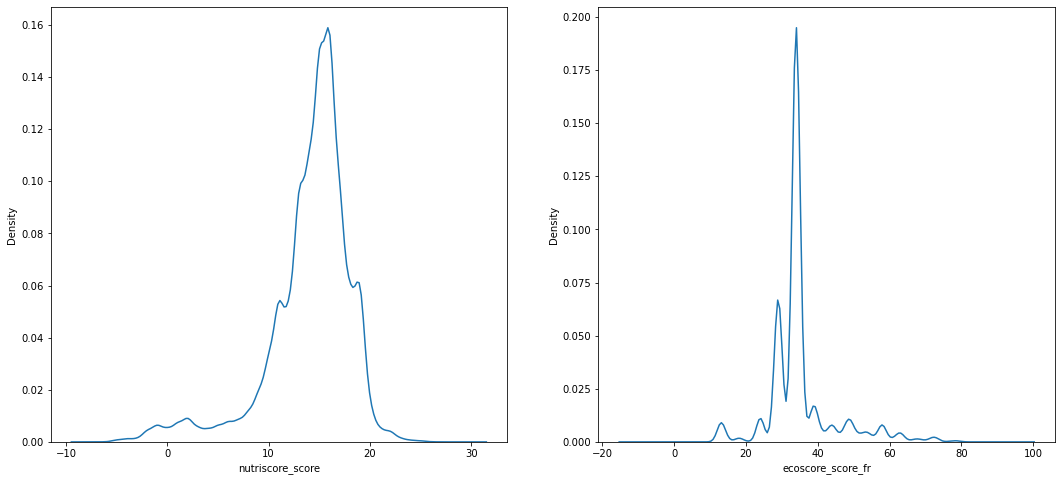

In [30]:
plt.figure(figsize=(18,8))
plt.subplot(121)
sns.kdeplot(df_cheese['nutriscore_score'])
plt.subplot(122)
sns.kdeplot(df_cheese['ecoscore_score_fr'])

#### répartition du nova group
le nova group est l'indice de "transformation" du produit, plus l'indice est grand, plus le produit est transformé.
on constate ici que les produits sont également répartis entre le groupe 3 et 4

<AxesSubplot:ylabel='nova_group'>

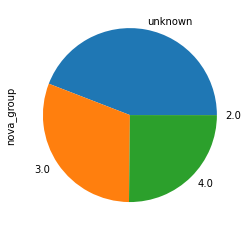

In [31]:
df_cheese['nova_group'].value_counts().plot.pie()

#### distribution des nutriments et apport energetique

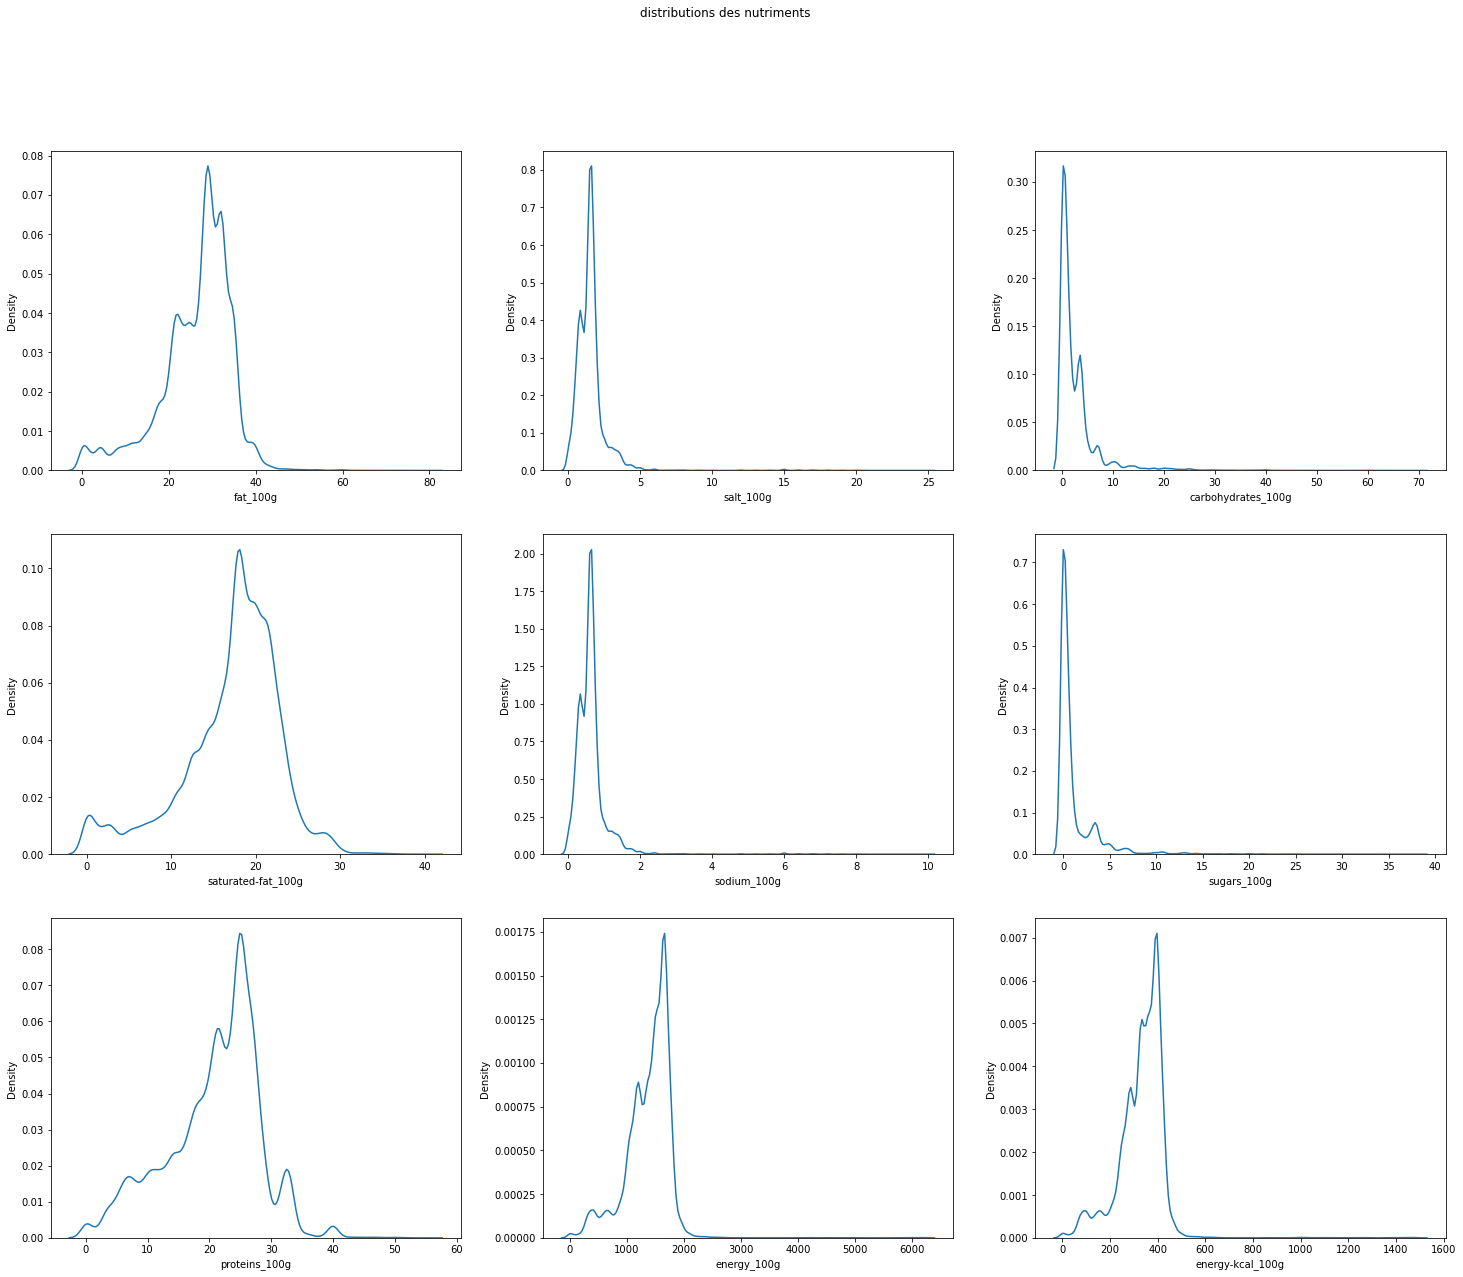

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(25,20))
nutri = ['fat_100g', 'saturated-fat_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'energy_100g', 'carbohydrates_100g', 'sugars_100g', 'energy-kcal_100g']
fig.suptitle('distributions des nutriments')
plot_index = 0
for i in range(3):
    for r in range(3):
        sns.kdeplot(df_cheese[nutri[plot_index]], ax=axes[r, i])
        plot_index += 1

## Matrice de corrélation
- la première heatmap montre la correlation de tout le tableau
- la dexieme heatmap ne garde que les variables qui ont un indice de correlation absolu superieur à 40%, et ne montre que ces indices-ci en questions

<AxesSubplot:>

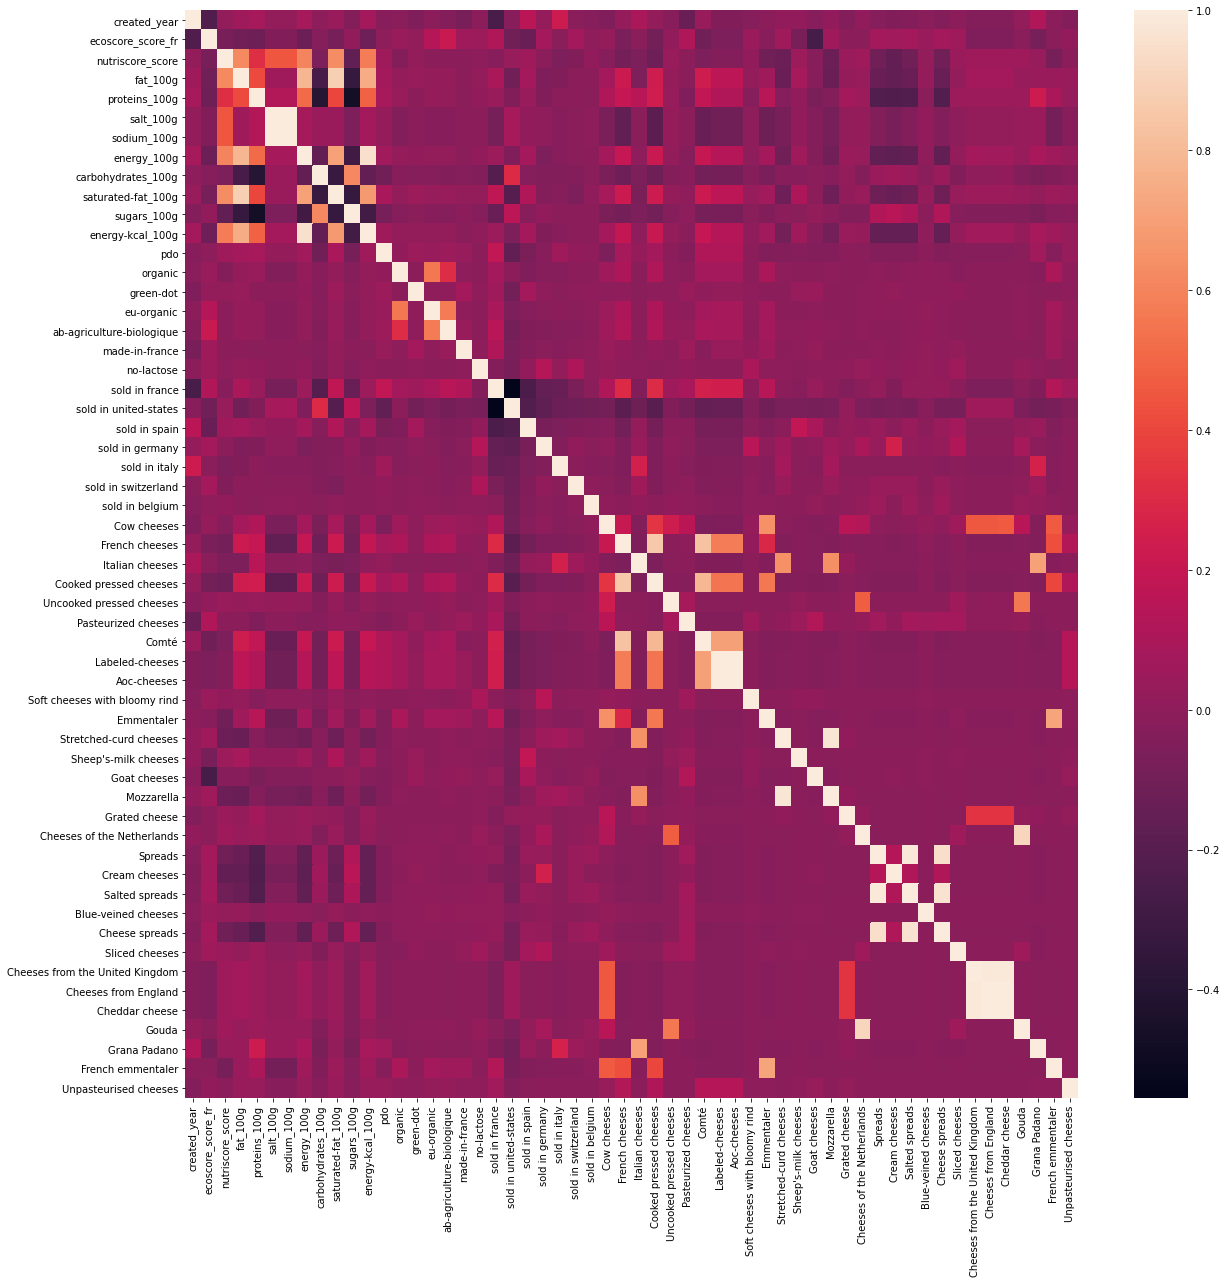

In [33]:
plt.figure(figsize=(20,20))
sns.heatmap(df_cheese.drop(['product_name', 'nova_group'], axis=1).corr())

<AxesSubplot:>

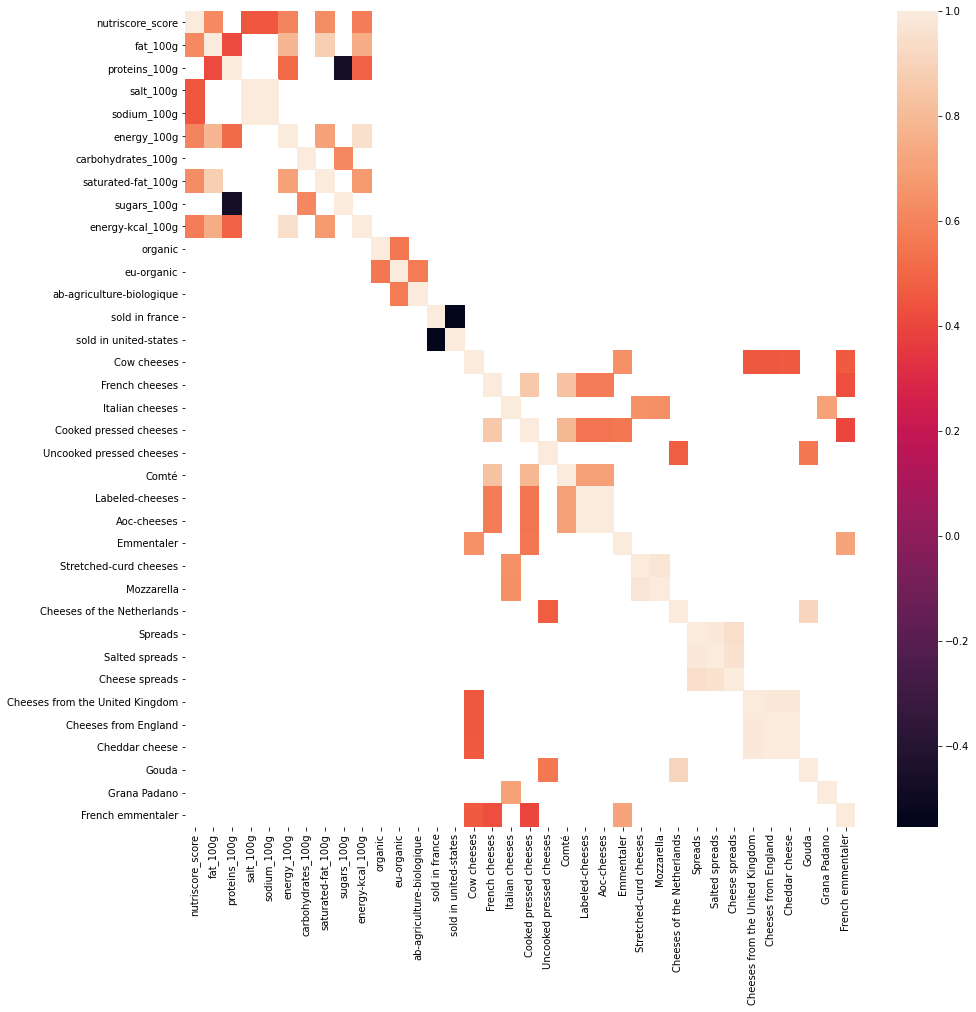

In [34]:
true_corr = df_cheese.drop(['product_name', 'nova_group'], axis=1)
correl = true_corr.corr()
liste_seuil = correl[correl.abs() > 0.4].sum()
for i in true_corr.columns:
    if liste_seuil[i] == 1:
        true_corr.drop(i, axis=1, inplace=True)
plt.figure(figsize=(15,15))
sns.heatmap(true_corr.corr()[true_corr.corr().abs() > 0.4])

pour finir on liste les correlations des plus au moins corrélés, avec comme indexe les deux variables corrélées, et en valeur, l'indice de correlation.

In [35]:
true_corr = df_cheese.drop(['product_name', 'nova_group'], axis=1)
liste_correl = topCorrel(true_corr, 0.4)
print(liste_correl)

<ipython-input-26-767eec509734>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  liste_top = pd.Series()


salt_100g - sodium_100g                                   1.000000
Labeled-cheeses - Aoc-cheeses                             0.999169
Cheeses from England - Cheddar cheese                     0.998302
Spreads - Salted spreads                                  0.985463
Cheeses from the United Kingdom - Cheeses from England    0.984156
Cheeses from the United Kingdom - Cheddar cheese          0.982474
Stretched-curd cheeses - Mozzarella                       0.975428
Salted spreads - Cheese spreads                           0.961281
energy_100g - energy-kcal_100g                            0.956780
Spreads - Cheese spreads                                  0.947212
Cheeses of the Netherlands - Gouda                        0.910750
fat_100g - saturated-fat_100g                             0.882463
French cheeses - Cooked pressed cheeses                   0.856976
French cheeses - Comté                                    0.831182
Cooked pressed cheeses - Comté                            0.78

## Analyse multivariée
on reprend comme avant la distribution du nutriscore, ecoscore, nova group, et les nutriments, mais cette fois ci en distinguant les produits vendus en France et les autres

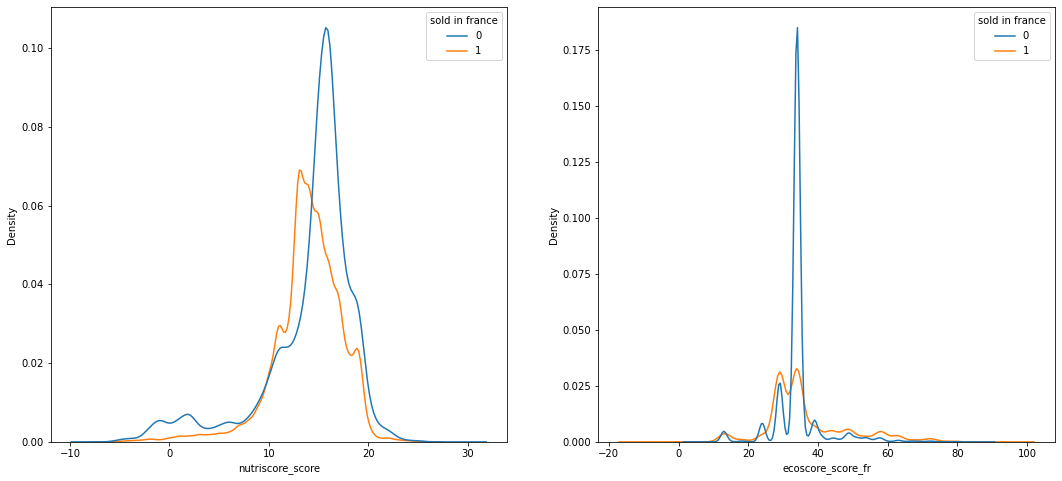

la moyenne du nutriscore pour la france : 13.9 et pour les autres pays : 14.1
la moyenne de l'ecoscore pour la france : 36.3 et pour les autres pays : 34.2


In [37]:
plt.figure(figsize=(18,8))
plt.subplot(121)
sns.kdeplot(data=df_cheese, x="nutriscore_score", hue="sold in france")
plt.subplot(122)
sns.kdeplot(data=df_cheese, x="ecoscore_score_fr", hue="sold in france")
plt.show()
print('la moyenne du nutriscore pour la france : ' + str(df_cheese[df_cheese['sold in france'] == 1]['nutriscore_score'].mean())[:4] + ' et pour les autres pays : ' + str(df_cheese[df_cheese['sold in france'] == 0]['nutriscore_score'].mean())[:4])
print('la moyenne de l\'ecoscore pour la france : ' + str(df_cheese[df_cheese['sold in france'] == 1]['ecoscore_score_fr'].mean())[:4] + ' et pour les autres pays : ' + str(df_cheese[df_cheese['sold in france'] == 0]['ecoscore_score_fr'].mean())[:4])

<AxesSubplot:xlabel='nova_group', ylabel='count'>

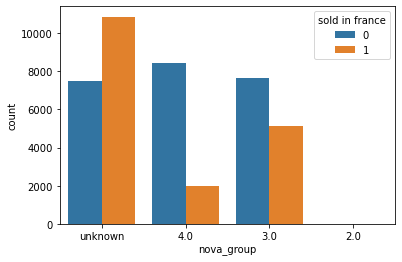

In [38]:
sns.countplot(data=df_cheese, x='nova_group', hue='sold in france')

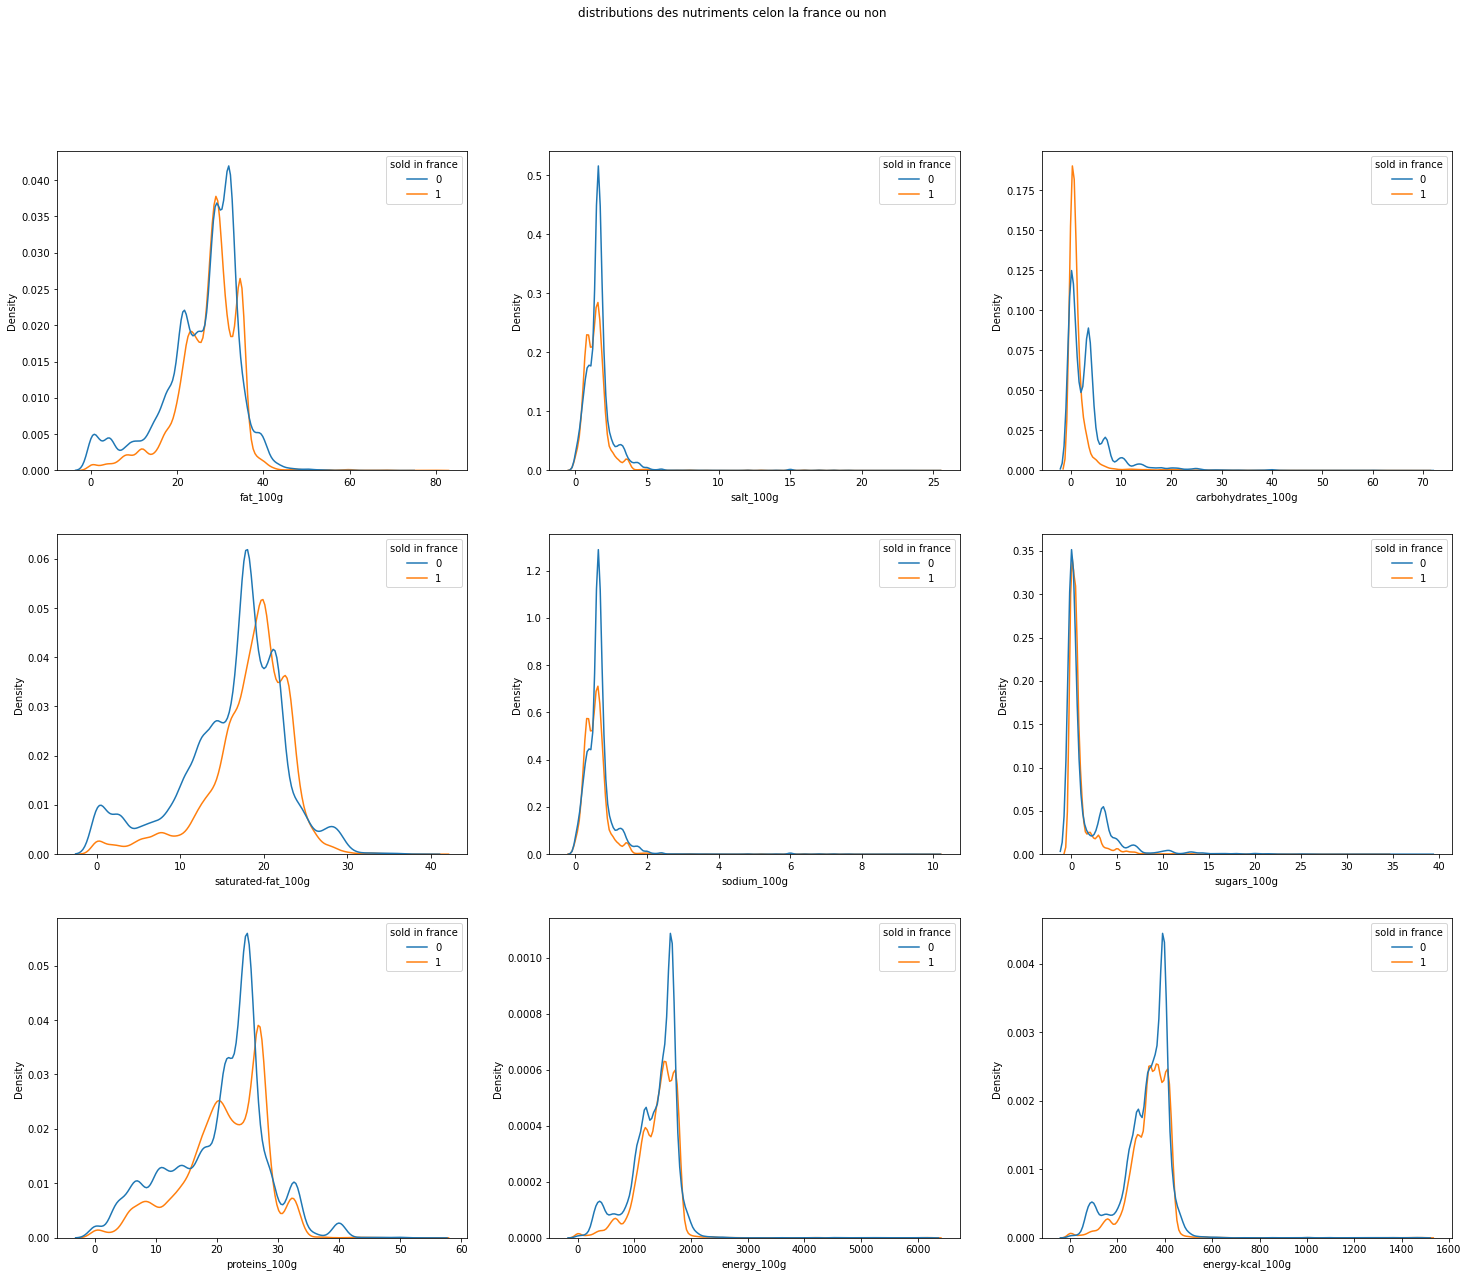

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(25,20))
nutri = ['fat_100g', 'saturated-fat_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'energy_100g', 'carbohydrates_100g', 'sugars_100g', 'energy-kcal_100g']
fig.suptitle('distributions des nutriments celon la france ou non')
plot_index = 0
for i in range(3):
    for r in range(3):
        sns.kdeplot(data=df_cheese,x=nutri[plot_index],hue='sold in france', ax=axes[r, i])
        plot_index += 1

In [40]:
print('la moyenne du gras saturé pour la france : ' + str(df_cheese[df_cheese['sold in france'] == 1]['saturated-fat_100g'].mean())[:4] + ' et pour les autres pays : ' + str(df_cheese[df_cheese['sold in france'] == 0]['saturated-fat_100g'].mean())[:4] + ' pour 100g')

la moyenne du gras saturé pour la france : 18.2 et pour les autres pays : 16.1 pour 100g


### correlation des produits vendus en France

In [41]:
df_cheese.corr()['sold in france'].sort_values()

sold in united-states             -0.554498
created_year                      -0.254371
sold in spain                     -0.242573
carbohydrates_100g                -0.205708
sold in germany                   -0.149299
sold in italy                     -0.140210
sugars_100g                       -0.133741
sodium_100g                       -0.083590
salt_100g                         -0.083589
sold in switzerland               -0.064592
Cheddar cheese                    -0.060005
Cheeses from England              -0.059851
Cheeses from the United Kingdom   -0.058920
Cream cheeses                     -0.050397
Grana Padano                      -0.049852
Italian cheeses                   -0.045133
Grated cheese                     -0.039213
no-lactose                        -0.035655
nutriscore_score                  -0.025047
Sheep's-milk cheeses              -0.021433
Gouda                             -0.014652
sold in belgium                   -0.014636
Cheeses of the Netherlands      

<AxesSubplot:xlabel='ab-agriculture-biologique', ylabel='count'>

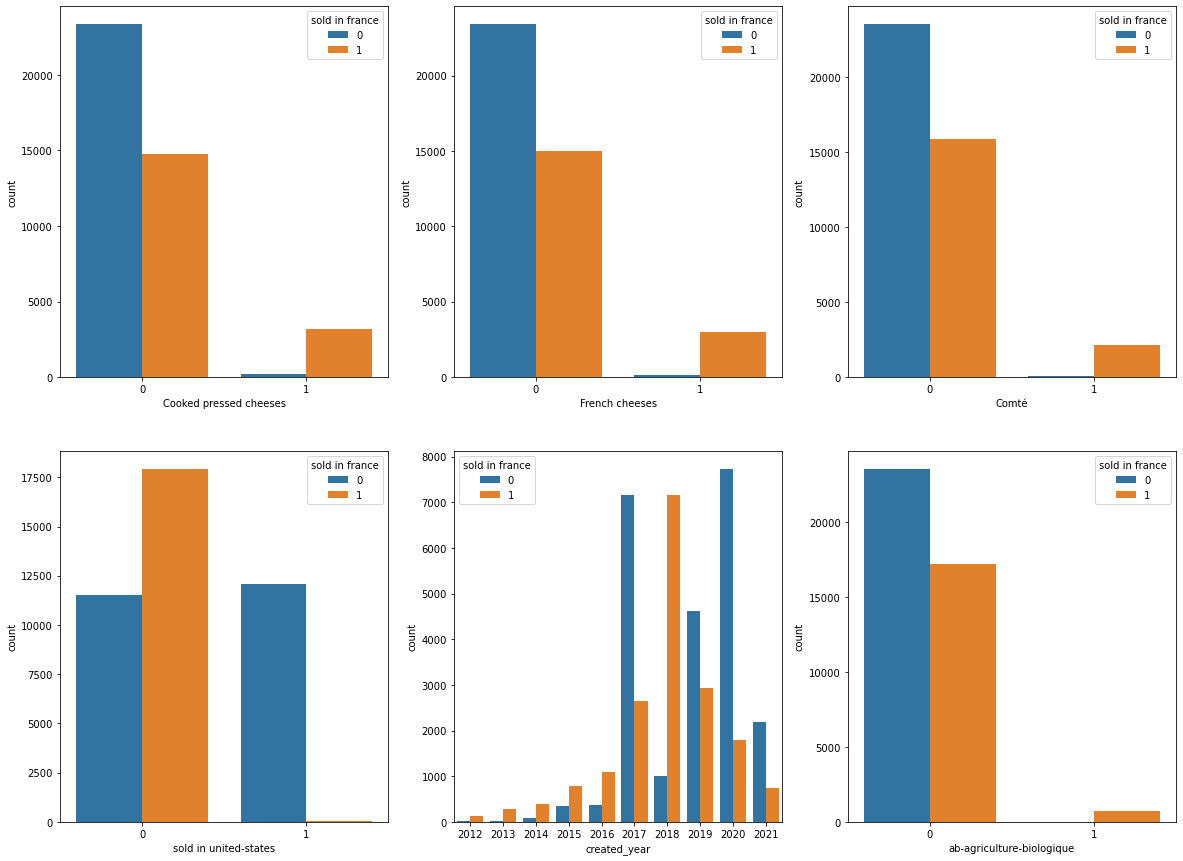

In [15]:
plt.figure(figsize=(20,15))
plt.subplot(231)
sns.countplot(data=df_cheese, x='Cooked pressed cheeses', hue='sold in france')
plt.subplot(232)
sns.countplot(data=df_cheese, x='French cheeses', hue='sold in france')
plt.subplot(233)
sns.countplot(data=df_cheese, x='Comté', hue='sold in france')
plt.subplot(234)
sns.countplot(data=df_cheese, x='sold in united-states', hue='sold in france')
plt.subplot(235)
sns.countplot(data=df_cheese, x='created_year', hue='sold in france')
plt.subplot(236)
sns.countplot(data=df_cheese, x='ab-agriculture-biologique', hue='sold in france')

<AxesSubplot:xlabel='ecoscore_score_fr', ylabel='Density'>

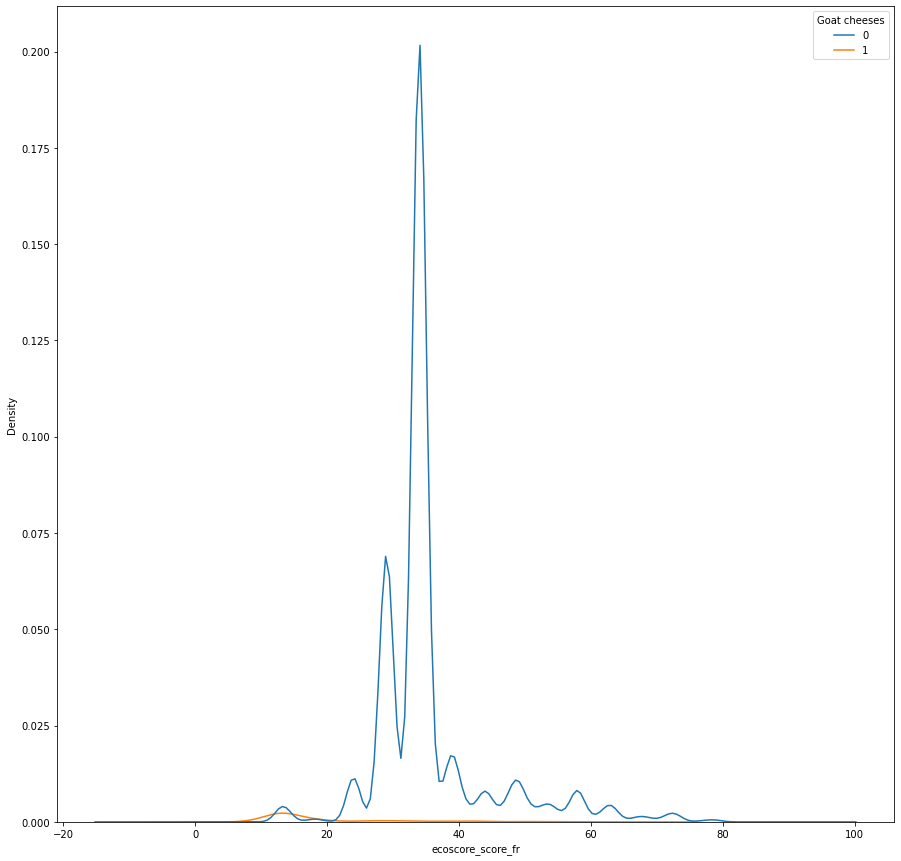

In [6]:
plt.figure(figsize=(15,15))
sns.kdeplot(data=df_cheese, x="ecoscore_score_fr", hue="Goat cheeses")

## ACP
On va effectuer une ACP sur le dataset, pour :
- optimiser le jeu de donnée
- remettre en évidence les relations entre les variables
- constater la variabilité entre les individus

In [44]:
df_acp = df_cheese.drop(['product_name', 'created_year', 'nova_group'], axis=1)
X = df_acp.values
features = df_acp.columns
names = df_cheese['product_name']

In [45]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [46]:
n_comp = 40
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=40)

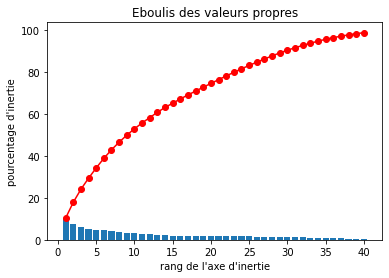

In [47]:
display_scree_plot(pca)

In [48]:
for i in range(n_comp):
    if pca.explained_variance_ratio_[i] < 1/n_comp:
        liste_comp_principal = pca.explained_variance_ratio_[:i]
        break

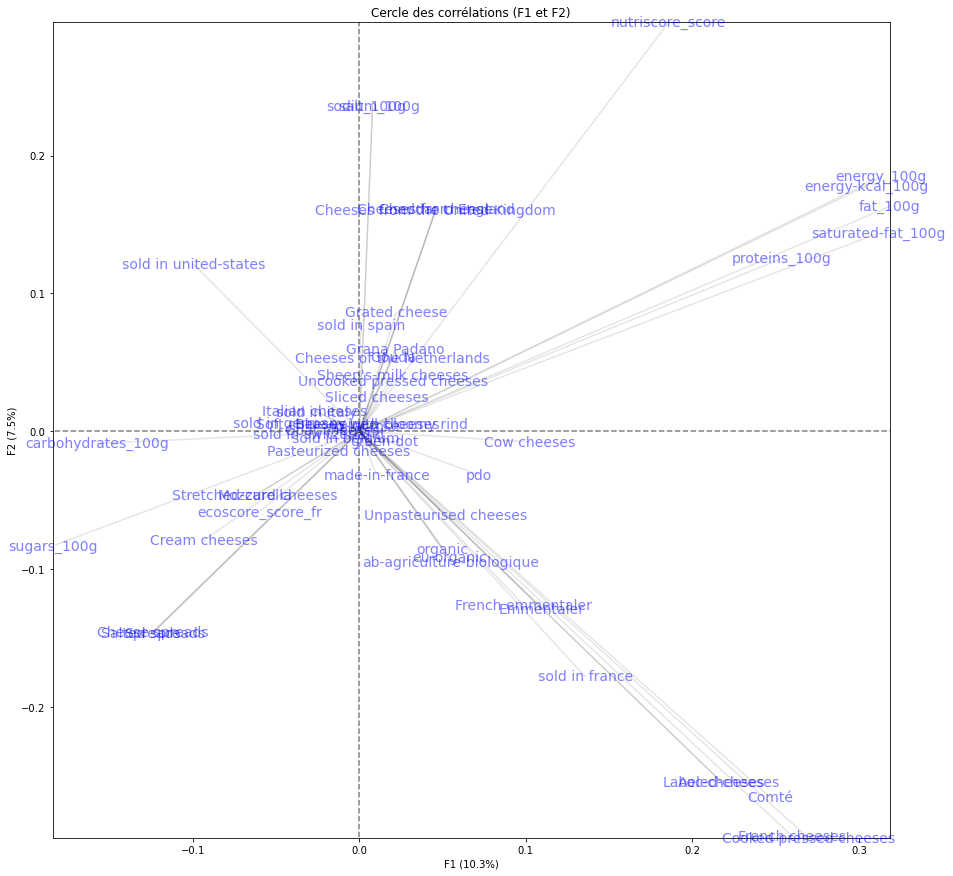

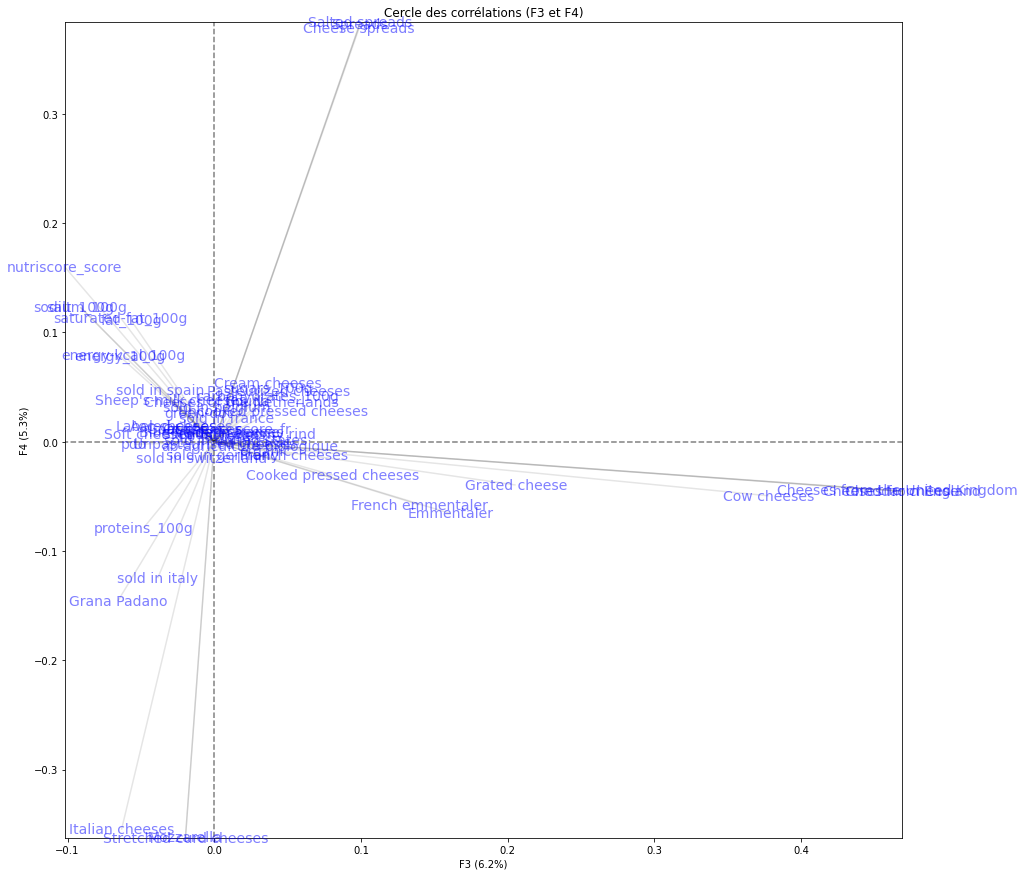

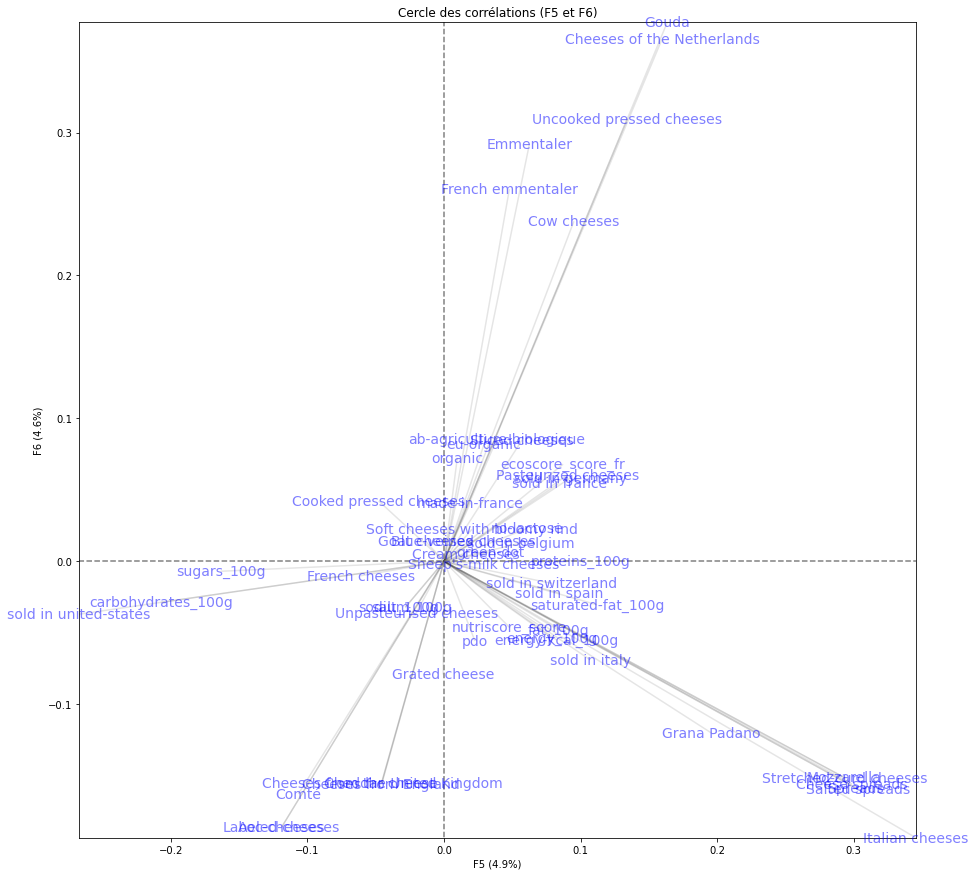

In [49]:
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

## avancement actuel

In [207]:
df_cheese[['Comté', 'Emmentaler', 'Mozzarella', 'Cheddar cheese', 'Gouda']].sum(axis=1).value_counts()

0    37004
1     5158
dtype: int64

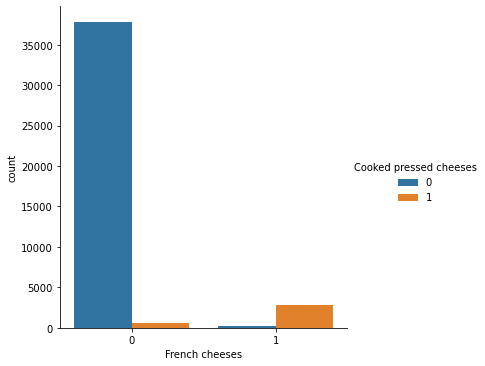

In [18]:
sns.catplot(data=df_cheese, x='French cheeses', hue='Cooked pressed cheeses', kind='count')

<AxesSubplot:xlabel='saturated-fat_100g', ylabel='Density'>

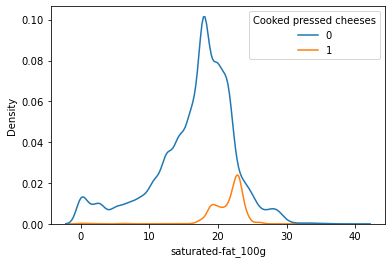

In [28]:
sns.kdeplot(data=df_cheese, x="saturated-fat_100g", hue="Cooked pressed cheeses")

In [30]:
df_cheese.corr()['ecoscore_score_fr'].sort_values()

Goat cheeses                      -0.264797
created_year                      -0.226949
sold in spain                     -0.131348
energy_100g                       -0.125531
proteins_100g                     -0.118258
energy-kcal_100g                  -0.114062
Comté                             -0.105192
fat_100g                          -0.103999
sold in united-states             -0.103879
Cooked pressed cheeses            -0.094120
saturated-fat_100g                -0.085374
Grana Padano                      -0.080934
nutriscore_score                  -0.078897
Sheep's-milk cheeses              -0.076228
French cheeses                    -0.070601
Aoc-cheeses                       -0.062511
Labeled-cheeses                   -0.062136
Cheddar cheese                    -0.056345
Cheeses from England              -0.056084
Cheeses from the United Kingdom   -0.053558
salt_100g                         -0.047217
sodium_100g                       -0.047216
carbohydrates_100g              